# OpenSense data format for personal weather station data used to generate an AMS PWS dataset
Example how an open PWS dataset can be transformed into a netCDF with the data format defined 
by the [OpenSense](https://opensenseaction.eu/) community.


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import urllib
import zipfile
import matplotlib.pyplot as plt

## Load a public dataset
Dowload and unpack data and metadata from the Amsterdam PWS data set:  
https://data.4tu.nl/articles/dataset/Rainfall_observations_datasets_from_Personal_Weather_Stations/12703250

In [2]:
# define data source and local path
url = "https://data.4tu.nl/ndownloader/files/24056603"
url= 'https://data.4tu.nl/file/fa404032-4fb2-483d-bb9c-af043a25990c/da8b1115-88fa-45ec-97df-3d3d43e4ffaa'
local_path = 'tmp_data/deVos_2019_PWS/'

# create local folder
if not os.path.exists(local_path):
    os.makedirs(local_path)

# download to local folder
local_file_name = url.split("/")[-1]
request_return_meassage = urllib.request.urlretrieve(
    url, os.path.join(local_path, local_file_name)
)

# unzip data
with zipfile.ZipFile(os.path.join(local_path, local_file_name)) as zfile:
    zfile.extractall(local_path)

In [3]:
# read data
pws_meta = pd.read_csv(os.path.join(local_path,"AMS_metadata.csv"))
pws_data = pd.read_csv(os.path.join(local_path,"AMS_dataset.csv"), index_col=0, parse_dates=True)

## Create a `xarray.Dataset` in the desired format

In [4]:
# creates a xarray data set from the imput data and assigns coordinates
# according to the OPENSENSE standards defined in the white paper
ds = pws_data.to_xarray().to_array(dim="id")
ds = ds.rename({"Time": "time"})
ds = ds.to_dataset(name="rainfall")

In [5]:
# creates elevation coordinate and fills it with np.nan since this
# information is not available in the AMS PWS data set
ds = ds.assign_coords({"elevation": xr.full_like(ds.id, np.nan)})

In [6]:
# assign lat and lon as coordinates with the dimension id
ds = ds.assign_coords(lat=("id", pws_meta.lat.values))
ds = ds.assign_coords(lon=("id", pws_meta.lon.values))

In [7]:
# set encoding attribute for time
ds.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"

In [8]:
ds

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) object 1kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation  (id) object 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
Data variables:
    rainfall   (id, time) float64 235MB 0.0 0.0 0.0 0.0 0.0 ... nan 0.0 0.0 0.0

## Add global attributes and attributes to variables and coordinates

In [9]:
# variable attributes
ds.rainfall.attrs = dict(
    name = "rainfall",
    long_name = "rainfall amount per time unit",
    units = "mm",
    coverage_contant_type = "physicalMeasurement")

# coordiante attributes
ds.time.attrs = dict(
    unit="seconds since 1970-01-01 00:00:00",
)
ds.lon.attrs = dict(units="degrees in WGS84 projection")
ds.lat.attrs = dict(units="degrees in WGS84 projection")
ds.elevation.attrs = dict(units="meters", longname="meters_above_sea")

# global Atrributes
ds.attrs["title"] = "PWS data from Amsterdam"
ds.attrs["file author"] = "Maximilian Graf"
ds.attrs["institution"] = "Wageningen University and Research, Department of Environmental Sciences"
ds.attrs["date"] = "2022-10-18 10:32:00"
ds.attrs["source"] = "Netamo PWS"
ds.attrs["history"] = "Data derived and reformated from the originally published dataset"
ds.attrs["naming convention"] = "OpenSense-0.1"
ds.attrs["license restrictions"] = "CC-BY 4.0 https://creativecommons.org/licenses/by/4.0/"
ds.attrs["reference"] = "https://doi.org/10.1029/2019GL083731"
ds.attrs["comment"] = ""

In [10]:
ds

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) object 1kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation  (id) object 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
Data variables:
    rainfall   (id, time) float64 235MB 0.0 0.0 0.0 0.0 0.0 ... nan 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## Save the `xarray.Dataset` as netCDF

In [11]:
# add conoding to compress the file
encoding = {
    "rainfall": {
        "dtype": "int32",
        "scale_factor": 0.001,
        "zlib": True,
        "_FillValue": -9999,
        "complevel": 3,
    }
}

In [12]:
# write the xarray dataset to netCDF file
ds.to_netcdf("ams_pws_full_period.nc", 
             encoding=encoding)

In [13]:
ds.rainfall

<xarray.DataArray 'rainfall' (id: 134, time: 219168)> Size: 235MB
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) object 1kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation  (id) object 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

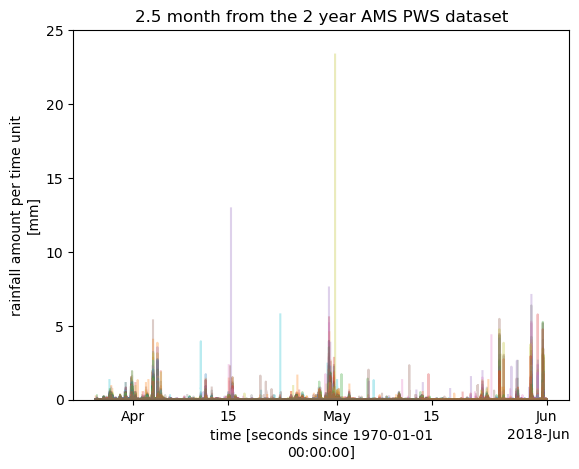

In [14]:
ds.rainfall.isel(time=range(200000,219168)).plot.line(x='time',add_legend=False,alpha=0.3)
plt.ylim(0,25)
plt.title("2.5 month from the 2 year AMS PWS dataset");

## Reference data based on radar data
Abbas El Hachem prepareda reference dataset based on openly availably radar data from KNMI. He used  20 random pixel within the area of the AMS PWS dataset. This dataset is currently avaiilable in [`pypwsqc`](https://github.com/OpenSenseAction/pypwsqc/tree/main/docs/notebooks/data) and stored here using the OpenSense concention for PWS/point based data.

In [15]:
ds_ref = xr.open_dataset("ams_gauges_full_period.nc")

In [16]:
ds_ref

<xarray.Dataset> Size: 3MB
Dimensions:    (id: 20, time: 18263)
Coordinates:
  * time       (time) datetime64[ns] 146kB 2016-05-01T01:00:00 ... 2018-05-31...
  * id         (id) <U2 160B '0' '1' '2' '3' '4' ... '15' '16' '17' '18' '19'
    elevation  (id) float64 160B ...
    lat        (id) float64 160B ...
    lon        (id) float64 160B ...
Data variables:
    rainfall   (id, time) float64 3MB ...
Attributes:
    title:                 Gauge adjusted radar data for Amsterdam
    file author:           Jochen Seidel
    institution:           University of Suttgart
    date:                  2024-08-14 10:32:00
    source:                KNMI
    history:               Data from KNMI
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

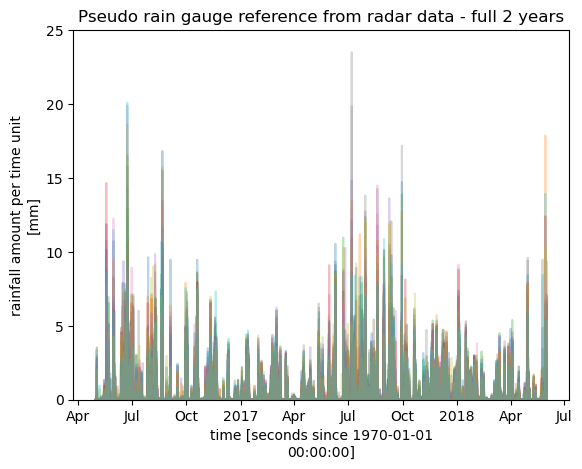

In [17]:
ds_ref.rainfall.plot.line(x='time',add_legend=False,alpha=0.3)
plt.ylim(0,25)
plt.title("Pseudo rain gauge reference from radar data - full 2 years");

## Calculate flags from de Vos et al 2019 and Bardossy et al 2021

to be done...
